## 使用稀疏回归测试(x,y)数据集

### 1.稀疏回归模型确定

In [42]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np

# 导入训练数据
df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]
yy = array[1:]

# 假设我们有 n 个时间点的观测数据 (x, y)
n = t.size  # 时间点数量
x = yy[0]    #x坐标
y = yy[1]    #y坐标
vx = yy[2]   #vx
vy = yy[3]   #vy

# 加速度的计算
r = np.sqrt(x**2 + y**2)   # 距离
G = 6.67430e-1     # 引力常数, m^3 kg^-1 s^-2
M = 1.989e30               # 太阳质量, kg
GM = G * M
x_ddot = -G * M * x / r**3
y_ddot = -G * M * y / r**3
print(x_ddot[:5],y_ddot[:5],x_ddot.size,y_ddot.size)

[-61350083.94794255 -61350014.29842156 -61349805.35006123
 -61349457.10346916 -61348969.55965822] [     -0.          -90966.95514488 -181933.68409433 -272899.960652
 -363865.55862371] 8760 8760


In [43]:
# 定义候选基函数
def build_design_matrix(x, y):
    # 计算分母项
    denominator = (x**2 + y**2)**(3/2)
    
    # 构建设计矩阵
    Theta = np.column_stack([
        np.ones(n),  # 常数项
        x,           # x
        y,           # y
        x**2,        # x^2
        y**2,        # y^2
        x * y,       # x * y
        GM * x / denominator,
        GM * y / denominator
    ])
    return Theta

# 构建生成矩阵
Theta = build_design_matrix(x, y)

# 输出生成矩阵的前 5 行
print("Design matrix (first 5 rows):")
print(Theta[:5])

Design matrix (first 5 rows):
[[1.00000000e+00 1.47100000e+11 0.00000000e+00 2.16384100e+22
  0.00000000e+00 0.00000000e+00 6.13500839e+07 0.00000000e+00]
 [1.00000000e+00 1.47099841e+11 2.18112820e+08 2.16383632e+22
  4.75732023e+16 3.20843611e+19 6.13500143e+07 9.09669551e+04]
 [1.00000000e+00 1.47099364e+11 4.36225169e+08 2.16382228e+22
  1.90292398e+17 6.41684448e+19 6.13498054e+07 1.81933684e+05]
 [1.00000000e+00 1.47098569e+11 6.54336574e+08 2.16379889e+22
  4.28156352e+17 9.62519733e+19 6.13494571e+07 2.72899961e+05]
 [1.00000000e+00 1.47097455e+11 8.72446564e+08 2.16376613e+22
  7.61163006e+17 1.28334669e+20 6.13489696e+07 3.63865559e+05]]


In [44]:
# 使用 LASSO 回归
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np

# 使用网格搜索选择 alpha
param_grid = {'alpha': np.logspace(-4, 1, 10)}
lasso = Lasso(max_iter=10000)
grid = GridSearchCV(lasso, param_grid, cv=5)
grid.fit(Theta, x_ddot)

best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

# 最优模型拟合
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(Theta, x_ddot)
coefficients_x = lasso.coef_

lasso.fit(Theta, y_ddot)
coefficients_y = lasso.coef_

# 输出结果
print("Coefficients for x_ddot:", coefficients_x)
print("Coefficients for y_ddot:", coefficients_y)


Best alpha: 0.0001
Coefficients for x_ddot: [ 0.00000000e+00 -3.96653620e-04 -2.31216920e-11 -1.31525901e-16
  6.62801169e-19 -3.18554031e-23 -1.87746663e-03  5.66777989e-08]
Coefficients for y_ddot: [ 0.00000000e+00 -9.42947855e-10 -3.96388956e-04 -1.10520583e-21
 -7.88698444e-22 -1.32222772e-16  2.35941329e-06 -1.72364063e-03]


## 额外测试

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt

# 1. 数据读取和预处理
# 加载数据
data = pd.read_csv('../improved_data/xy_orbit.csv')

# 提取坐标和速度
x = data['position1-'].values/1e10
y = data['position2-'].values/1e10
vx = data['v_1'].values/1e10
vy = data['v_2'].values/1e10

# 计算距离 r 和加速度分量
r = np.sqrt(x**2 + y**2)
G = 6.67430e-11 * 86400**2/1e30  # 调整单位
M = 1.989e30  # 太阳质量
GM = G * M

# 加速度分量
x_ddot = -GM * x / r**3
y_ddot = -GM * y / r**3

# 2. 构建设计矩阵
def build_design_matrix(x, y, r, GM):
    denominator = r**3
    Theta = np.column_stack([
        np.ones(len(x)),  # 常数项
        x,
        y,
        x**2,
        y**2,
        x * y,
        GM * x / denominator,
        GM * y / denominator
    ])
    return Theta

# 构建设计矩阵
Theta = build_design_matrix(x, y, r, GM)

# 标准化特征和目标变量
scaler_X = StandardScaler()
scaler_y = StandardScaler()

Theta_scaled = scaler_X.fit_transform(Theta)
x_ddot_scaled = scaler_y.fit_transform(x_ddot.reshape(-1, 1)).ravel()
y_ddot_scaled = scaler_y.fit_transform(y_ddot.reshape(-1, 1)).ravel()

# 3. 使用 ElasticNet 进行稀疏回归
elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], 
                           alphas=np.logspace(-4, 1, 10), 
                           cv=5, 
                           max_iter=10000)

# 训练模型并获取 x_ddot 的系数
elastic_net.fit(Theta_scaled, x_ddot_scaled)
coefficients_x = elastic_net.coef_

# 训练模型并获取 y_ddot 的系数
elastic_net.fit(Theta_scaled, y_ddot_scaled)
coefficients_y = elastic_net.coef_

# 输出系数
print("ElasticNet Coefficients for x_ddot:", coefficients_x)
print("ElasticNet Coefficients for y_ddot:", coefficients_y)


LASSO Coefficients for x_ddot:
[ 0.         -0.74104483 -0.         -0.          0.00866383 -0.
 -0.24904849 -0.        ]

LASSO Coefficients for y_ddot:
[ 0.         -0.         -0.7327193  -0.          0.         -0.00812267
 -0.         -0.25764423]


c:\anacoda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+00, tolerance: 8.760e-01
  model = cd_fast.enet_coordinate_descent(
c:\anacoda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+00, tolerance: 8.760e-01
  model = cd_fast.enet_coordinate_descent(


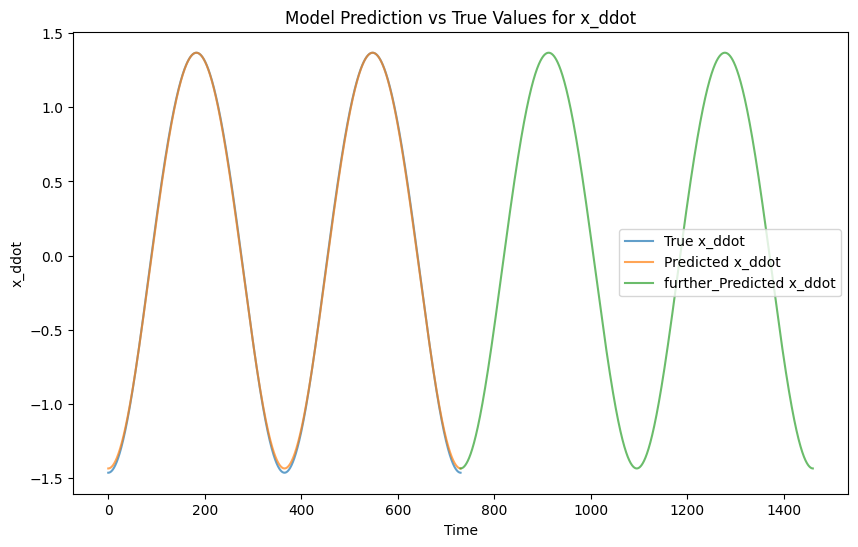

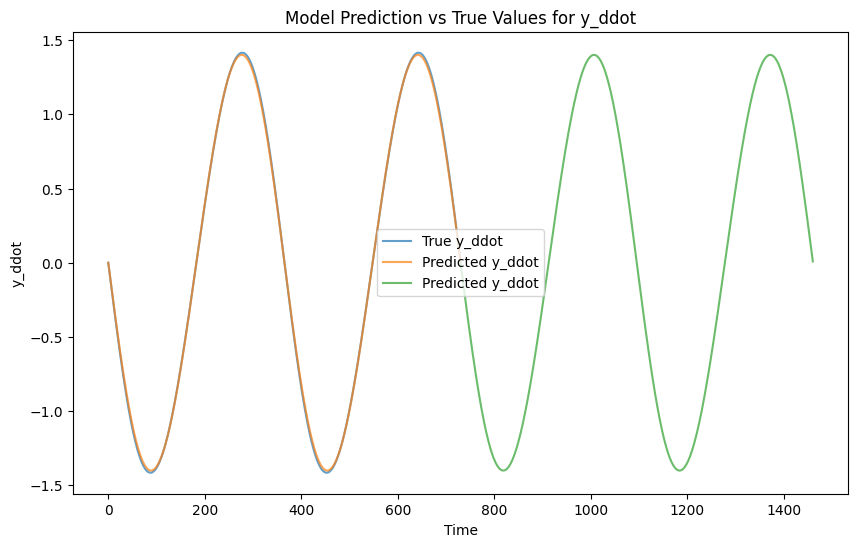

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 导入数据
df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]
yy = array[1:]

# 提取 x, y, vx, vy
x = yy[0]
y = yy[1]
vx = yy[2]
vy = yy[3]

# 计算加速度（x_ddot, y_ddot）
r = np.sqrt(x**2 + y**2)   # 距离
G = 6.67430e-11
G = G * 86400**2  # 将 G 调整为 m^3 kg^-1 s^-2
M = 1.989e30      # 太阳质量 (kg)
GM = G * M
x_ddot = -GM * x / r**3
y_ddot = -GM * y / r**3

# 构建设计矩阵
def build_design_matrix(x, y, r, GM):
    denominator = r**3
    Theta = np.column_stack([
        np.ones(len(x)),  # 常数项
        x,                # x
        y,                # y
        x**2,             # x^2
        y**2,             # y^2
        x * y,            # x * y
        GM * x / denominator,  # GM * x / r^3
        GM * y / denominator   # GM * y / r^3
    ])
    return Theta

# 构建设计矩阵
Theta = build_design_matrix(x, y, r, GM)

# 标准化设计矩阵
scaler = StandardScaler()
Theta_scaled = scaler.fit_transform(Theta)

# 对目标变量（加速度）进行标准化
x_ddot_scaled = StandardScaler().fit_transform(x_ddot.reshape(-1, 1)).flatten()
y_ddot_scaled = StandardScaler().fit_transform(y_ddot.reshape(-1, 1)).flatten()

# 使用 LASSO 回归进行拟合
lasso_x = Lasso(alpha=0.01)  # alpha 是正则化参数
lasso_x.fit(Theta_scaled, x_ddot_scaled)  # 拟合 x_ddot

lasso_y = Lasso(alpha=0.01)  # alpha 是正则化参数
lasso_y.fit(Theta_scaled, y_ddot_scaled)  # 拟合 y_ddot

# 输出系数
print("LASSO Coefficients for x_ddot:")
print(lasso_x.coef_)

print("\nLASSO Coefficients for y_ddot:")
print(lasso_y.coef_)

# 绘制预测值与真实值的对比
x_ddot_pred = lasso_x.predict(Theta_scaled)
y_ddot_pred = lasso_y.predict(Theta_scaled)

# 检验泛化能力：
df2 = pd.read_csv('../improved_data/xy_orbit_test.csv')
array2 = df2.to_numpy()
array2 = array2.T
t2 = array2[0]
yy2 = array2[1:]

x2 = yy2[0]
y2 = yy2[1]
vx2 = yy2[2]
vy2 = yy2[3]

r2 = np.sqrt(x2**2 + y2**2)   # 距离
G = 6.67430e-11  # 将 G 调整为 m^3 kg^-1 s^-2
M = 1.989e30      # 太阳质量 (kg)
GM = G * M
x_ddot2 = -GM * x / r2**3
y_ddot2 = -GM * y / r2**3

x_ddot_pred2 = lasso_x.predict(Theta_scaled)
y_ddot_pred2 = lasso_y.predict(Theta_scaled)

Theta2 = build_design_matrix(x2, y2, r2, GM)

# 标准化设计矩阵
scaler = StandardScaler()
Theta_scaled2 = scaler.fit_transform(Theta2)

plt.figure(figsize=(10, 6))
plt.plot(t, x_ddot_scaled, label="True x_ddot", alpha=0.7)
plt.plot(t, x_ddot_pred, label="Predicted x_ddot", alpha=0.7)
plt.plot(t2, x_ddot_pred2, label="further_Predicted x_ddot", alpha=0.7)
plt.legend()
plt.title("Model Prediction vs True Values for x_ddot")
plt.xlabel("Time")
plt.ylabel("x_ddot")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, y_ddot_scaled, label="True y_ddot", alpha=0.7)
plt.plot(t, y_ddot_pred, label="Predicted y_ddot", alpha=0.7)
plt.plot(t2, y_ddot_pred2, label="Predicted y_ddot", alpha=0.7)
plt.legend()
plt.title("Model Prediction vs True Values for y_ddot")
plt.xlabel("Time")
plt.ylabel("y_ddot")
plt.show()


## 根据观测，能够一定程度的学习到加速度的变换，接下来，根据稀疏回归加速度的表达式，是否能够得到合理的轨迹呢？
#### 1.对于一个归一化的系数学习到参数，完全不能符合，对于真实数据的计算，直接溢出。

In [ ]:
print(lasso_x.coef_.size,lasso_x.coef_)
print(lasso_y.coef_.size,lasso_y.coef_)

C:\Users\19464\AppData\Local\Temp\ipykernel_21056\2436736901.py:7: RuntimeWarning: overflow encountered in scalar power
  ax = lasso_x.coef_[1]*x + lasso_x.coef_[4]*y**2 + lasso_x.coef_[5]*G*M*x/r1**3
C:\Users\19464\AppData\Local\Temp\ipykernel_21056\2436736901.py:8: RuntimeWarning: overflow encountered in scalar power
  ay = lasso_y.coef_[2]*y + lasso_y.coef_[5]*x*y + lasso_y.coef_[5]*G*M*y/r1**3
C:\Users\19464\AppData\Local\Temp\ipykernel_21056\2436736901.py:6: RuntimeWarning: overflow encountered in scalar power
  r1 = np.sqrt(r[0]**2+r[1]**2)
C:\Users\19464\AppData\Local\Temp\ipykernel_21056\2436736901.py:8: RuntimeWarning: overflow encountered in scalar multiply
  ay = lasso_y.coef_[2]*y + lasso_y.coef_[5]*x*y + lasso_y.coef_[5]*G*M*y/r1**3
C:\Users\19464\AppData\Local\Temp\ipykernel_21056\2436736901.py:7: RuntimeWarning: invalid value encountered in scalar add
  ax = lasso_x.coef_[1]*x + lasso_x.coef_[4]*y**2 + lasso_x.coef_[5]*G*M*x/r1**3
C:\Users\19464\AppData\Local\Temp\ipyker

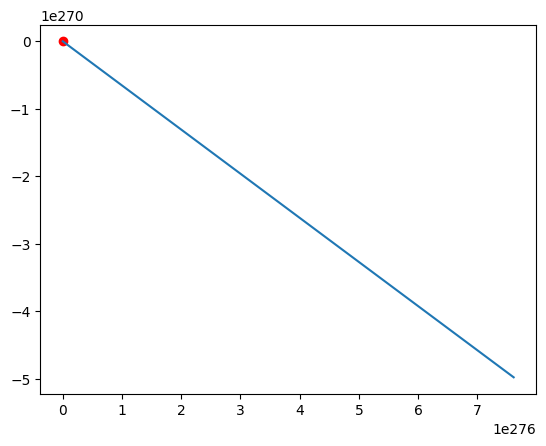

In [5]:

lasso_x.coef_ = [ 0, -0.74104483, 0, 0, 0.00866383, 0, 0.24904849, 0]
lasso_y.coef_ = [ 0, 0, -0.7327193, 0, 0, -0.00812267,0, -0.25764423]
def acc(G,M,r):
    x = r[0]
    y = r[1]
    r1 = np.sqrt(r[0]**2+r[1]**2)
    ax = lasso_x.coef_[1]*x + lasso_x.coef_[4]*y**2 + lasso_x.coef_[5]*G*M*x/r1**3
    ay = lasso_y.coef_[2]*y + lasso_y.coef_[5]*x*y + lasso_y.coef_[5]*G*M*y/r1**3
    return np.array([ax, ay])

def speed(v,a,dt):
    return v + a*dt

def posi(r,v,dt):
    return r + v*dt

v0 = np.array([0,30.28*1e3])
r0 = np.array([1.471*1e11,0])
dt = 24*60*60*0.05

times = []
r_posi = []
v_speed= []
for i in range(10000):
    if i ==0:
        a = acc(G,M,r0)
        v = speed(v0, a, dt)
        r = posi(r0, v, dt)
    else:
        a = acc(G,M,r)
        v = speed(v, a, dt)
        r = posi(r, v, dt)
    v_speed.append(v)
    times.append(i)
    r_posi.append(r)
time = np.array(times)
rr = np.array(r_posi)
vv = np.array(v_speed)
vv = vv.T
rr = rr.T

#plt.gca().set_aspect('equal', adjustable='box')
plt.plot(rr[0],rr[1])
plt.scatter(0,0,color='red')
plt.show()
